# Tap dependent impedance of transformers

With an adjustment of a tap position of a transformer, the number of windings is adjusted, which influences the impedence. The user can provide **trafo_characteristic_table** of the dependance of the variables **voltage ratio**, **angle in degree**, **vk_percent** and **vkr_percent** on the tap position. A helper function in pandapower control module converts the provided points in a characteristic object with quadratic spline interpolation (or a user-defined characteristic object with a custom interpolation approach) and writes it in the **trafo_characteristic_spline** table. Finally, a diagnostic function checks for inconsistensies and provides information to the user.

In [1]:
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.control

In [2]:
def add_trafo_connection(net, hv_bus, element_type="trafo"):
    cb = pp.create_bus(net, vn_kv=0.4)
    pp.create_load(net, cb, 0.2, 0.05)

    if element_type == "trafo3w":
        cbm = pp.create_bus(net, vn_kv=0.9)
        pp.create_load(net, cbm, 0.1, 0.03)
        pp.create_transformer3w_from_parameters(
            net,
            hv_bus=hv_bus,
            mv_bus=cbm,
            lv_bus=cb,
            vn_hv_kv=20.0,
            vn_mv_kv=0.9,
            vn_lv_kv=0.45,
            sn_hv_mva=0.6,
            sn_mv_mva=0.5,
            sn_lv_mva=0.4,
            vk_hv_percent=1.0,
            vk_mv_percent=1.0,
            vk_lv_percent=1.0,
            vkr_hv_percent=0.3,
            vkr_mv_percent=0.3,
            vkr_lv_percent=0.3,
            pfe_kw=0.2,
            i0_percent=0.3,
            tap_neutral=0.0,
            tap_pos=2,
            tap_changer_type="Ratio",
            tap_step_percent=1.0,
            tap_min=-2,
            tap_max=2,
        )
    else:
        pp.create_transformer(
            net, hv_bus=hv_bus, lv_bus=cb, std_type="0.25 MVA 20/0.4 kV", tap_pos=2
        )


def create_net():
    net = pp.create_empty_network()
    vn_kv = 20
    b1 = pp.create_bus(net, vn_kv=vn_kv)
    pp.create_ext_grid(net, b1, vm_pu=1.01)
    b2 = pp.create_bus(net, vn_kv=vn_kv)
    l1 = pp.create_line_from_parameters(
        net,
        b1,
        b2,
        12.2,
        r_ohm_per_km=0.08,
        x_ohm_per_km=0.12,
        c_nf_per_km=300,
        max_i_ka=0.2,
        df=0.8,
    )
    for i in range(2):
        add_trafo_connection(net, b2)
        net.trafo.loc[i, "id_characteristic_table"] = i
        net.trafo.loc[i, "tap_dependency_table"] = True

    # Adding the characteristics data for two- and three-winding transformers into the trafo_characteristic_table
    net["trafo_characteristic_table"] = pd.DataFrame(
        columns=[
            "id_characteristic",
            "step",
            "voltage_ratio",
            "angle_deg",
            "vk_percent",
            "vkr_percent",
            "vkr_hv_percent",
            "vkr_mv_percent",
            "vkr_lv_percent",
            "vk_hv_percent",
            "vk_mv_percent",
            "vk_lv_percent",
        ]
    )
    trafo_data = {
        "id_characteristic": [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        "step": [-2, -1, 0, 1, 2, -2, -1, 0, 1, 2],
        "voltage_ratio": [0.95, 0.97, 1.0, 1.03, 1.05, 0.95, 0.97, 1.0, 1.03, 1.05],
        "angle_deg": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        "vk_percent": [5, 5.2, 6, 6.8, 7, 5, 5.2, 6, 6.8, 7],
        "vkr_percent": [1.3, 1.4, 1.44, 1.5, 1.6, 1.3, 1.4, 1.44, 1.5, 1.6],
        "vkr_hv_percent": np.nan,
        "vkr_mv_percent": np.nan,
        "vkr_lv_percent": np.nan,
        "vk_hv_percent": np.nan,
        "vk_mv_percent": np.nan,
        "vk_lv_percent": np.nan,
    }

    net["trafo_characteristic_table"] = pd.DataFrame(trafo_data)

    trafo3w_data = {
        "id_characteristic": [2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
        "step": [-2, -1, 0, 1, 2, -2, -1, 0, 1, 2],
        "voltage_ratio": [0.95, 0.97, 1.0, 1.03, 1.05, 0.95, 0.97, 1.0, 1.03, 1.05],
        "angle_deg": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        "vk_percent": np.nan,
        "vkr_percent": np.nan,
        "vkr_hv_percent": [0.27, 0.28, 0.3, 0.32, 0.33, 0.27, 0.28, 0.3, 0.32, 0.33],
        "vkr_mv_percent": [0.27, 0.28, 0.3, 0.32, 0.33, 0.27, 0.28, 0.3, 0.32, 0.33],
        "vkr_lv_percent": [0.27, 0.28, 0.3, 0.32, 0.33, 0.27, 0.28, 0.3, 0.32, 0.33],
        "vk_hv_percent": [0.85, 0.9, 1, 1.1, 1.15, 0.85, 0.9, 1, 1.1, 1.15],
        "vk_mv_percent": [0.85, 0.9, 1, 1.1, 1.15, 0.85, 0.9, 1, 1.1, 1.15],
        "vk_lv_percent": [0.85, 0.9, 1, 1.1, 1.15, 0.85, 0.9, 1, 1.1, 1.15],
    }
    data_frame = pd.DataFrame(trafo3w_data)
    net["trafo_characteristic_table"] = pd.concat(
        [net["trafo_characteristic_table"], data_frame], sort=False
    )
    return net

In [3]:
net = create_net()

We can create the characteristics by generating characteristic objects and assigning them to the respective columns in the **trafo_characteristic_spline table**. To create these characteristics, a convenience function can be used to initialize and configure the characteristic objects for **voltage ratio**, **angle in degree**, **vk_percent** and **vkr_percent**. This function creates the characteristics for all transfomers within the specified network. It is essential that the input parameters are provided in the correct order to ensure proper functionality.

In [4]:
pp.control.create_trafo_characteristic_object(net)
net.trafo.loc[1, "id_characteristic_table"] = np.nan
net.trafo.loc[1, "tap_dependency_table"] = False
net.trafo

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\auxiliary.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  net["trafo_characteristic_spline"] = net["trafo_characteristic_spline_temp"].applymap(


,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_step_percent,tap_step_degree,tap_pos,tap_changer_type,id_characteristic_table,tap_dependency_table,parallel,df,in_service,id_characteristic_spline
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,...,2.5,0.0,2,Ratio,0,True,1,1.0,True,0
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,...,2.5,0.0,2,Ratio,<NA>,False,1,1.0,True,1


The characteristic set in the convenience function is the SplineCharacteristic object that relies on quadratic spline interpolation with interp1d from SciPy. Let us check the characteristic:

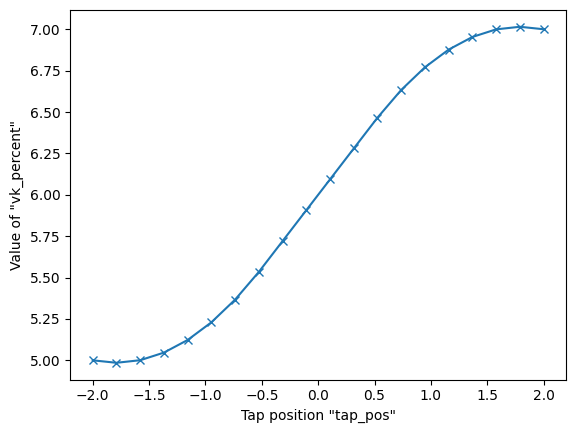

In [5]:
pp.control.plot_characteristic(
    net["trafo_characteristic_spline"]["vk_percent_characteristic"].loc[0],
    -2,
    2,
    xlabel='Tap position "tap_pos"',
    ylabel='Value of "vk_percent"',
)

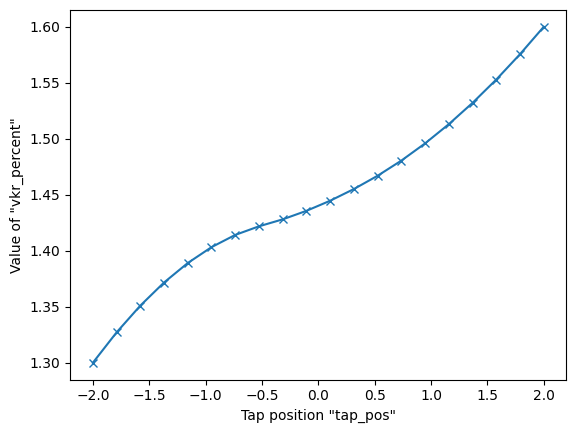

In [6]:
pp.control.plot_characteristic(
    net["trafo_characteristic_spline"]["vkr_percent_characteristic"].loc[0],
    -2,
    2,
    xlabel='Tap position "tap_pos"',
    ylabel='Value of "vkr_percent"',
)

In [7]:
pp.runpp(net)

Let us verify that the adjusted values were considered in the calculation:

In [8]:
net.res_bus.loc[[2, 3]]

,vm_pu,va_degree,p_mw,q_mvar
2,0.931359,-153.390736,0.2,0.05
3,0.935414,-152.890645,0.2,0.05


We can see that the voltage values are different, even though the connections are identical. Now let us compare the computation time:

In [9]:
net2 = create_net()
net2.trafo["id_characteristic_table"] = np.nan
net2.trafo["tap_dependency_table"] = False

In [10]:
%timeit pp.runpp(net2)

11.5 ms ± 387 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%timeit pp.runpp(net)

15.8 ms ± 245 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The calculation with tap dependent impedance is somewhat slower.

Now, let us compare the performance of the controller for reference

In [12]:
net3 = create_net()
net3.trafo.loc[1, "id_characteristic_table"] = np.nan
net3.trafo.loc[1, "tap_dependency_table"] = False
pp.control.SplineCharacteristic(net3, [-2, -1, 0, 1, 2], [5, 5.2, 6, 6.8, 7])
pp.control.SplineCharacteristic(net3, [-2, -1, 0, 1, 2], [1.3, 1.4, 1.44, 1.5, 1.6])
pp.control.TapDependentImpedance(net3, [0], 0, output_variable="vk_percent")
pp.control.TapDependentImpedance(net3, [0], 1, output_variable="vkr_percent")

This TapDependentImpedance has the following parameters: 

index:             1
json_excludes:     ['self', '__class__']

In [13]:
%timeit pp.runpp(net3, run_control=True)

18.8 ms ± 538 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The computational time is substantially higher!

The results from using the characteristics in pandapower directly and via controllers are identical:

In [14]:
net3.res_bus.loc[[2, 3]]

,vm_pu,va_degree,p_mw,q_mvar
2,0.931359,-153.390736,0.2,0.05
3,0.935414,-152.890645,0.2,0.05


In [15]:
assert np.allclose(net.res_bus.vm_pu, net3.res_bus.vm_pu, atol=1e-6, rtol=0)
assert np.allclose(net.res_bus.va_degree, net3.res_bus.va_degree, atol=1e-6, rtol=0)

# 3-Winding Transformers

In [16]:
net4 = create_net()
net5 = create_net()
for i in range(2):
    add_trafo_connection(net4, net4.trafo.at[0, "hv_bus"], "trafo3w")
    add_trafo_connection(net5, net5.trafo.at[0, "hv_bus"], "trafo3w")

In [17]:
net4.trafo3w.loc[0, "id_characteristic_table"] = 2
net4.trafo3w.loc[0, "tap_dependency_table"] = True
pp.control.create_trafo_characteristic_object(net4)

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\auxiliary.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  net["trafo_characteristic_spline"] = net["trafo_characteristic_spline_temp"].applymap(


In [18]:
pp.control.SplineCharacteristic(net5, [-2, -1, 0, 1, 2], [0.85, 0.9, 1, 1.1, 1.15])
pp.control.SplineCharacteristic(net5, [-2, -1, 0, 1, 2], [0.27, 0.28, 0.3, 0.32, 0.33])

SplineCharacteristic

In [19]:
pp.control.TapDependentImpedance(
    net5, [0], 0, output_variable="vk_hv_percent", element="trafo3w"
)
pp.control.TapDependentImpedance(
    net5, [0], 1, output_variable="vkr_hv_percent", element="trafo3w"
)
pp.control.TapDependentImpedance(
    net5, [0], 0, output_variable="vk_mv_percent", element="trafo3w"
)
pp.control.TapDependentImpedance(
    net5, [0], 1, output_variable="vkr_mv_percent", element="trafo3w"
)
pp.control.TapDependentImpedance(
    net5, [0], 0, output_variable="vk_lv_percent", element="trafo3w"
)
pp.control.TapDependentImpedance(
    net5, [0], 1, output_variable="vkr_lv_percent", element="trafo3w"
)

This TapDependentImpedance has the following parameters: 

index:             5
json_excludes:     ['self', '__class__']

In [20]:
%timeit pp.runpp(net4)

26.2 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%timeit pp.runpp(net5, run_control=True)

41.9 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
assert np.allclose(net4.res_bus.vm_pu, net5.res_bus.vm_pu, atol=1e-6, rtol=0)
assert np.allclose(net4.res_bus.va_degree, net5.res_bus.va_degree, atol=1e-6, rtol=0)
pd.merge(
    net4.res_bus[["vm_pu", "va_degree"]],
    net5.res_bus[["vm_pu", "va_degree"]],
    left_index=True,
    right_index=True,
)

,vm_pu_x,va_degree_x,vm_pu_y,va_degree_y
0,1.010000,0.000000,1.010000,0.000000
1,1.007329,-0.199678,1.007329,-0.199678
2,0.929303,-153.505686,0.929303,-153.505686
3,0.929303,-153.505686,0.929303,-153.505686
4,1.129082,-0.545199,1.129082,-0.545199
5,1.004785,-0.428464,1.004785,-0.428464
6,1.129548,-0.497491,1.129548,-0.497491
7,1.005072,-0.396841,1.005072,-0.396841


Also in the case of the 3-winding transformers, the results for direct calculation in pandapower and in controllers match.

# Undefined characteristics

If some transformers have characteristics that do not define all columns, the missing characteristics are ignored by default. However, if **tap_dependency_table** is set to True, one or more characteristics are missing, a warning is issued, followed by an error during the load flow calculation.

In [23]:
net6 = create_net()

In [24]:
net6.trafo.loc[1, "tap_dependency_table"] = False
net6["trafo_characteristic_table"].loc[
    net["trafo_characteristic_table"]["id_characteristic"] == 1, "vk_percent"
] = np.nan
pp.control.create_trafo_characteristic_object(net6)
net6.trafo

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\auxiliary.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  net["trafo_characteristic_spline"] = net["trafo_characteristic_spline_temp"].applymap(


,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_step_percent,tap_step_degree,tap_pos,tap_changer_type,id_characteristic_table,tap_dependency_table,parallel,df,in_service,id_characteristic_spline
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,...,2.5,0.0,2,Ratio,0,True,1,1.0,True,0
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,...,2.5,0.0,2,Ratio,1,False,1,1.0,True,1


In [25]:
%timeit pp.runpp(net6)

16.4 ms ± 571 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
# this would raise a warning:
# net6.trafo.loc[1,"tap_dependency_table"] = True
# pp.control.util.diagnostic.trafo_characteristic_table_diagnostic(net6)

In [27]:
# this would raise an error:
# pp.runpp(net6)

# Creating transformers with characteristics

The functions to create transformers have been updated to include the parameters **tap_dependency_table** and **id_characteristic_table** in trasformer which help to create the characteristics object and add the references to the **id_characteristic_spline** in trasformer using **create_trafo_characteristic_object** function.

In [28]:
net_create = create_net()

In [29]:
net_create.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_changer_type,id_characteristic_table,tap_dependency_table,parallel,df,in_service
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,...,2,2.5,0.0,2,Ratio,0,True,1,1.0,True
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,...,2,2.5,0.0,2,Ratio,1,True,1,1.0,True


In [30]:
pp.create_transformer(
    net_create,
    hv_bus=net_create.trafo.at[0, "hv_bus"],
    lv_bus=net_create.trafo.at[0, "lv_bus"],
    std_type="0.25 MVA 20/0.4 kV",
    tap_pos=2,
    tap_dependency_table=True,
    id_characteristic_table=0,
)
pp.control.create_trafo_characteristic_object(net_create)

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\auxiliary.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  net["trafo_characteristic_spline"] = net["trafo_characteristic_spline_temp"].applymap(


In [31]:
net_create.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_step_percent,tap_step_degree,tap_pos,tap_changer_type,id_characteristic_table,tap_dependency_table,parallel,df,in_service,id_characteristic_spline
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,...,2.5,0.0,2,Ratio,0,True,1,1.0,True,0
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,...,2.5,0.0,2,Ratio,1,True,1,1.0,True,1
2,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,6.0,1.44,0.8,...,2.5,0.0,2,Ratio,0,True,1,1.0,True,0


In [32]:
pp.runpp(net_create)

# File I/O

The file I/O for characteristics is now implemented via adding the characteristic table:

In [33]:
net2 = pp.from_json_string(pp.to_json(net))
pp.control.create_trafo_characteristic_object(
    net2
)  # need to recreate the object becuase it is binary

net2["trafo_characteristic_spline"]

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\auxiliary.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  net["trafo_characteristic_spline"] = net["trafo_characteristic_spline_temp"].applymap(


,id_characteristic,voltage_ratio_characteristic,angle_deg_characteristic,vk_percent_characteristic,vkr_percent_characteristic,vk_hv_percent_characteristic,vkr_hv_percent_characteristic,vk_mv_percent_characteristic,vkr_mv_percent_characteristic,vk_lv_percent_characteristic,vkr_lv_percent_characteristic
0,0,SplineCharacteristic,SplineCharacteristic,SplineCharacteristic,SplineCharacteristic,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


De-serialization is working:

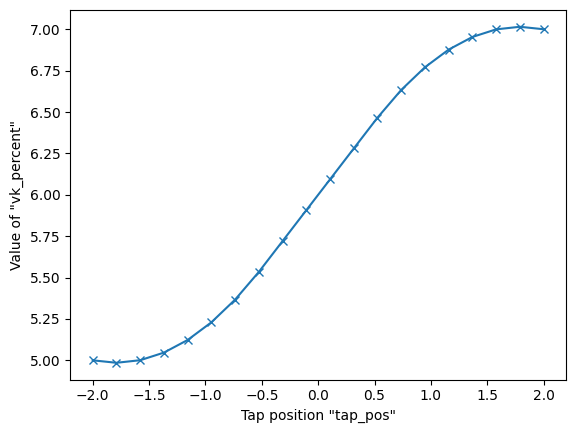

In [34]:
pp.control.plot_characteristic(
    net2["trafo_characteristic_spline"]["vk_percent_characteristic"].loc[0],
    -2,
    2,
    xlabel='Tap position "tap_pos"',
    ylabel='Value of "vk_percent"',
)

# Diagnostic

The diagnostic function for transformer characteristics checks the following:
 
* Are there transformer characteristic table and tap-dependent characteristics?
* Are any characteristics missing?
* Are there **tap_dependency_table**, **tap_changer_type** and **id_characteristic_table** missing in net.trafo or net.trafo3w?
* Check if all relevant columns for creating transformer characteristics are populated in the **trafo_characteristic_table**
* Check the data types of **tap_dependency_table** and **id_characteristic_table**
* Are there any missing **id_characteristic_table** values in the **trafo_characteristic_table**?

The results are displayed to the user with the help of warning statements.

In [35]:
net.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_step_percent,tap_step_degree,tap_pos,tap_changer_type,id_characteristic_table,tap_dependency_table,parallel,df,in_service,id_characteristic_spline
0,None,0.25 MVA 20/0.4 kV,1,2,0.25,20.0,0.4,7.0,1.60,0.8,...,2.5,0.0,2,Ratio,0,True,1,1.0,True,0
1,None,0.25 MVA 20/0.4 kV,1,3,0.25,20.0,0.4,6.0,1.44,0.8,...,2.5,0.0,2,Ratio,<NA>,False,1,1.0,True,1


In [36]:
pp.control.util.diagnostic.trafo_characteristic_table_diagnostic(net)

True

In [37]:
pp.control.util.diagnostic.trafo_characteristic_table_diagnostic(net6)

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\diagnostic.py:89: UserWarning: trafo: found 1 transformer(s) with not both tap_dependency_table and id_characteristic_table parameters populated. Power flow calculation will raise an error.
  warnings.warn(f"{trafo_table}: found {mismatch_a} transformer(s) with not both "
C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\diagnostic.py:109: UserWarning: There are some transformers in the trafo table with not all characteristics populated in the trafo_characteristic_table.
  warnings.warn(f"There are some transformers in the {trafo_table} table with not all "


False

In [38]:
net_diagnostics = net
net_diagnostics.trafo.loc[0, "id_characteristic_table"] = None
pp.control.util.diagnostic.trafo_characteristic_table_diagnostic(net_diagnostics)
# UserWarning: trafo: found 1 transformer(s) with not both tap_dependency_table and id_characteristic_table parameters populated. Power flow calculation will raise an error.
#  warnings.warn(f"{trafo_table}: found {mismatch_a} transformer(s) with not both "

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\diagnostic.py:89: UserWarning: trafo: found 1 transformer(s) with not both tap_dependency_table and id_characteristic_table parameters populated. Power flow calculation will raise an error.
  warnings.warn(f"{trafo_table}: found {mismatch_a} transformer(s) with not both "


False

In [39]:
net_diagnostics.trafo.loc[0, "id_characteristic_table"] = 0
net_diagnostics.trafo.loc[0, "tap_changer_type"] = None
pp.control.util.diagnostic.trafo_characteristic_table_diagnostic(net_diagnostics)
# UserWarning: trafo: found 1 transformer(s) with tap_dependency_table set to True and tap_changer_type parameter not populated. The characteristics from trafo_characteristic_table will not be considered.
# warnings.warn(f"{trafo_table}: found {mismatch_b} transformer(s) with tap_dependency_table set to "

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\diagnostic.py:98: UserWarning: trafo: found 1 transformer(s) with tap_dependency_table set to True and tap_changer_type parameter not populated. The characteristics from trafo_characteristic_table will not be considered.
  warnings.warn(f"{trafo_table}: found {mismatch_b} transformer(s) with tap_dependency_table set to "


False